## Imports

In [1]:
import pickle
import os
import sys
import numpy as np
import torch
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
import argparse
import psutil
import GPUtil

# Define the base path where your pickle file is located
base_path2 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli'
base_path3 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240412-172636'
base_path1_at_same_time = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240413-164417'
base_path_original = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133'
base_path_shuffled = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-shuffled-20240416-102831'

In [2]:
# CPU utilization
print(psutil.cpu_percent(interval=1))

# Memory utilization
print(psutil.virtual_memory())

# GPU details (via third-party libraries like GPUtil)
for gpu in GPUtil.getGPUs():
    print("GPU id: {0}, Load: {1}%, Free Memory: {2}MB, Used Memory: {3}MB".format(gpu.id, gpu.load*100, gpu.memoryFree, gpu.memoryUsed))


1.3
svmem(total=1081963773952, available=1017222946816, percent=6.0, used=57216802816, free=335886118912, active=407751421952, inactive=306670542848, buffers=6150811648, cached=682710040576, shared=912568320, slab=25467838464)
GPU id: 0, Load: 0.0%, Free Memory: 81050.0MB, Used Memory: 0.0MB
GPU id: 1, Load: 100.0%, Free Memory: 55865.0MB, Used Memory: 25184.0MB
GPU id: 2, Load: 100.0%, Free Memory: 55865.0MB, Used Memory: 25184.0MB


## Model Configuration

In [3]:
# Construct the full path to the 'args.pkl' file
args_file_path2 = os.path.join(base_path2, 'args.pkl')

# Load the arguments from the pickle file
with open(args_file_path2, 'rb') as f:
    args2 = pickle.load(f)

# Convert the Namespace to a dictionary if it is of that type
if isinstance(args2, argparse.Namespace):
    args_dict2 = vars(args2)
else:
    print("The loaded 'args' object is not an argparse.Namespace. Its type is:", type(args2))
    exit()

# Determine the maximum width of the argument names for alignment
max_key_length = max(len(key) for key in args_dict2.keys())

# Print the arguments in a structured table format
print(f"{'Argument':<{max_key_length}} | Value")
print("-" * (max_key_length + 3) + "+" + "-" * 30)  # Adjust 30 if you expect wider values

for key, value in args_dict2.items():
    print(f"{key:<{max_key_length}} | {value}")

Argument            | Value
----------------------+------------------------------
data_train          | /home/bosfab01/SpeakerVerificationBA/data/audioset2M_librispeech960.json
data_val            | /home/bosfab01/SpeakerVerificationBA/data/audioset_eval.json
data_eval           | None
label_csv           | /home/bosfab01/SpeakerVerificationBA/data/label_information.csv
n_class             | 527
dataset             | asli
dataset_mean        | -3.6925695
dataset_std         | 4.020388
target_length       | 1024
num_mel_bins        | 128
exp_dir             | ./exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli
lr                  | 0.0001
warmup              | True
optim               | adam
batch_size          | 24
num_workers         | 16
n_epochs            | 9
lr_patience         | 2
adaptschedule       | False
n_print_steps       | 100
save_model          | True
freqm               | 0
timem               | 0
mixup               | 0.0
bal                 | none
fstride   

## Epochs, Iterations and Time Required

### Compare the time required for training the model with 2 and 3 GPUs

In [4]:
# open progress files
with open(os.path.join(base_path2, 'progress.pkl'), 'rb') as f:
    progress2 = pickle.load(f)

with open(os.path.join(base_path3, 'progress.pkl'), 'rb') as f:
    progress3 = pickle.load(f)

with open(os.path.join(base_path_original, 'progress.pkl'), 'rb') as f:
    progress_original = pickle.load(f)

with open(os.path.join(base_path_shuffled, 'progress.pkl'), 'rb') as f:
    progress_shuffled = pickle.load(f)

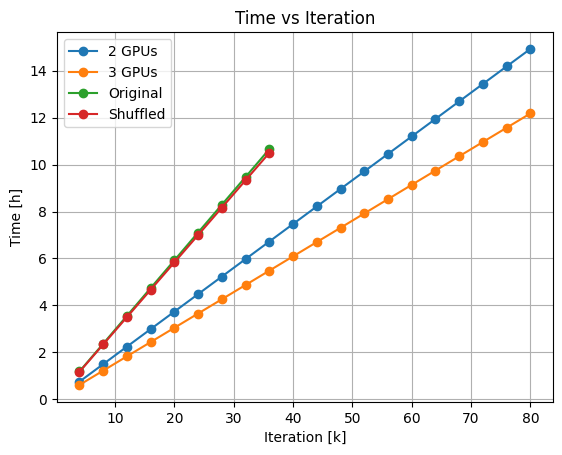

In [5]:
# get the iteration (is at the second position in the list of progress)
iteration2 = np.array([x[1] for x in progress2])
iteration3 = np.array([x[1] for x in progress3])
iteration_original = np.array([x[1] for x in progress_original])
iteration_shuffled = np.array([x[1] for x in progress_shuffled])

# get time (is at the fourth position in the list of progress)
time2 = np.array([x[3] for x in progress2])
time3 = np.array([x[3] for x in progress3])
time_original = np.array([x[3] for x in progress_original])
time_shuffled = np.array([x[3] for x in progress_shuffled])


# plot the time vs iteration for the first 20k iterations
plt.plot(iteration2[:20]/1e3, time2[:20]/3600, "o-", label='2 GPUs')
plt.plot(iteration3[:20]/1e3, time3[:20]/3600, "o-", label='3 GPUs')
plt.plot(iteration_original/1e3, time_original/3600, "o-", label='Original')
plt.plot(iteration_shuffled/1e3, time_shuffled/3600, "o-", label='Shuffled')
plt.xlabel('Iteration [k]')
plt.ylabel('Time [h]')
plt.title('Time vs Iteration')
plt.grid()
plt.legend()
plt.show()


Fitted line: y = 6.46x + 0.19
Sum of squares of residuals: 365.4275283693382


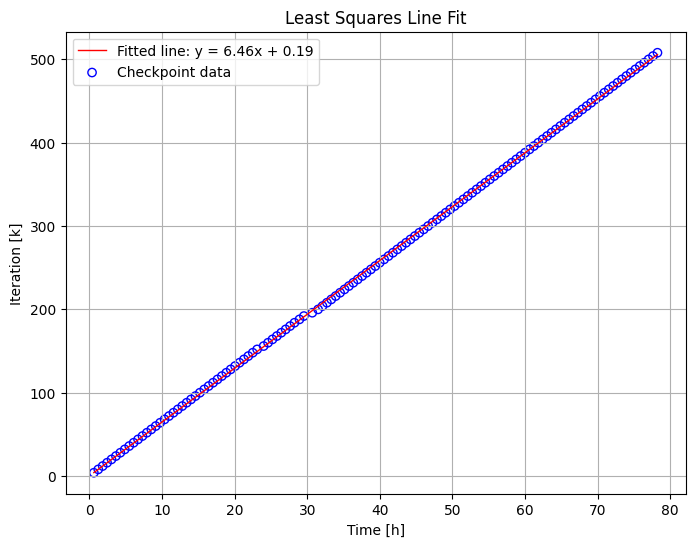

In [6]:
# convert to hours and kilo iterations
time3_h = time3 / 3600
iteration3_k = iteration3 / 1e3

# Step 1: Fit the line
# np.polyfit returns the coefficients [m, q] of the fit y = mx + q
m, q = np.polyfit(time3_h, iteration3_k, 1)

# Step 2: Calculate the predicted values
predicted_iteration3_k = m * time3_h + q

# Step 3: Compute the residuals
residuals = iteration3_k - predicted_iteration3_k

# Step 4: Calculate the sum of the squares of the residuals
sum_of_squares = np.sum(residuals**2)

# Printing the model parameters and the sum of squares
print("Fitted line: y = {:.2f}x + {:.2f}".format(m, q))
print("Sum of squares of residuals:", sum_of_squares)

# Plotting the original data and the fitted line
plt.figure(figsize=(8, 6))
plt.scatter(time3_h, iteration3_k, color='blue', marker='o', facecolors='none', label='Checkpoint data')
plt.plot(time3_h, predicted_iteration3_k, color='red', label=f'Fitted line: y = {m:.2f}x + {q:.2f}', linewidth=1)  # Thinner line
plt.xlabel('Time [h]')
plt.ylabel('Iteration [k]')
plt.title('Least Squares Line Fit')
plt.legend()
plt.grid(True)

# Save the figure as a PDF file
#plt.savefig('least_squares_fit.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [7]:
# calculate total time required for all 800k iterations based on the number of iterations and the time per iteration
n_iterations = 800000
time_per_iteration2 = time2[10] / iteration2[10]
time_per_iteration3 = time3[10] / iteration3[10]
time_per_iteration_original = time_original[-1] / iteration_original[-1]
time_per_iteration_shuffled = time_shuffled[-1] / iteration_shuffled[-1]

total_time2 = time_per_iteration2 * n_iterations
total_time3 = time_per_iteration3 * n_iterations
total_time_original = time_per_iteration_original * n_iterations
total_time_shuffled = time_per_iteration_shuffled * n_iterations

print(f"Total time for 2 GPUs: {total_time2/3600:.2f} hours")
print(f"Total time for 3 GPUs: {total_time3/3600:.2f} hours")
print(f"Total time for original: {total_time_original/3600:.2f} hours")
print(f"Total time for shuffled: {total_time_shuffled/3600:.2f} hours")

Total time for 2 GPUs: 149.34 hours
Total time for 3 GPUs: 121.77 hours
Total time for original: 236.80 hours
Total time for shuffled: 233.31 hours


## Training and Evaluation Loss

In [8]:
# Construct the full path to the 'result.csv' file
result_file_path3 = os.path.join(base_path3, 'result.csv')

# Load the result from the csv file
result3 = np.genfromtxt(result_file_path3, delimiter=',')

# Extract the columns from the result
acc_train3 = result3[:, 0] # The first column
loss_train3 = result3[:, 1] # The second column
acc_eval3 = result3[:, 2] # The third column
mse_eval3 = result3[:, 3] # The fourth column

# Define the format for each column
header_format = " {:>5}  | {:<10} | {:<10} | {:<10} | {:<10}"
row_format = "{:>5}k  | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f}"

# Print the table headers
print(header_format.format("iter", "acc_train", "loss_train", "acc_eval", "mse_eval"))
print("-" * 60)  # Adjust the total length to fit your headers and column data

# Print the results in a structured table format
for i in range(len(acc_train3)):
    print(row_format.format((i + 1) * 10, acc_train3[i], loss_train3[i], acc_eval3[i], mse_eval3[i]))
    

  iter  | acc_train  | loss_train | acc_eval   | mse_eval  
------------------------------------------------------------
   10k  | 0.03638    | 6.53626    | 0.12381    | 0.04633   
   20k  | 0.18346    | 4.08722    | 0.17926    | 0.03929   
   30k  | 0.24399    | 3.67850    | 0.21716    | 0.03720   
   40k  | 0.28192    | 3.46191    | 0.24204    | 0.03624   
   50k  | 0.30816    | 3.31961    | 0.26271    | 0.03476   
   60k  | 0.32478    | 3.22170    | 0.27636    | 0.03400   
   70k  | 0.33650    | 3.15404    | 0.28437    | 0.03364   
   80k  | 0.34530    | 3.10050    | 0.29464    | 0.03313   
   90k  | 0.35270    | 3.05729    | 0.29902    | 0.03281   
  100k  | 0.35892    | 3.02134    | 0.30121    | 0.03266   
  110k  | 0.36521    | 2.98467    | 0.30772    | 0.03233   
  120k  | 0.37017    | 2.95689    | 0.31548    | 0.03229   
  130k  | 0.37478    | 2.93074    | 0.31804    | 0.03183   
  140k  | 0.37858    | 2.90999    | 0.32207    | 0.03182   
  150k  | 0.38266    | 2.88527    | 0.3

### compare the training and evaluation loss for the model trained with 2 and 3 GPUs

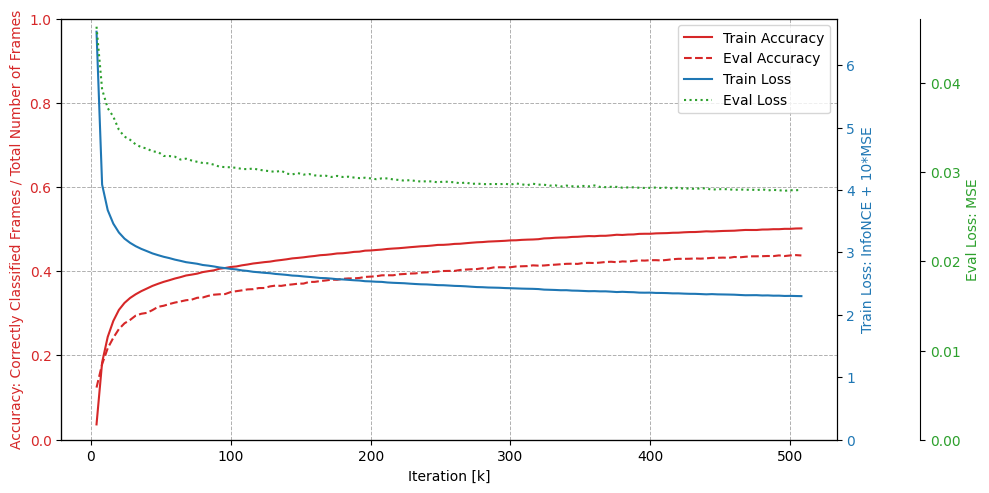

In [9]:
# Create a plot with a wider figure size
fig, ax1 = plt.subplots(figsize=(10, 5))  # You can adjust the size as needed

color_train = 'tab:red'
ax1.set_xlabel('Iteration [k]')
ax1.set_ylabel('Accuracy: Correctly Classified Frames / Total Number of Frames', color=color_train)
line5, = ax1.plot(iteration3 / 1e3, acc_train3, color=color_train, label='Train Accuracy')
line6, = ax1.plot(iteration3 / 1e3, acc_eval3, color=color_train, linestyle='dashed', label='Eval Accuracy')
ax1.tick_params(axis='y', labelcolor=color_train)
ax1.set_ylim(0, 1)  # Set the limit for the accuracy axis starting at 0

ax2 = ax1.twinx()
color_loss = 'tab:blue'
ax2.set_ylabel('Train Loss: InfoNCE + 10*MSE', color=color_loss)
line7, = ax2.plot(iteration3 / 1e3, loss_train3, color=color_loss, label='Train Loss')
ax2.tick_params(axis='y', labelcolor=color_loss)
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start y-axis at 0 for loss

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
color_eval_loss = 'tab:green'
ax3.set_ylabel('Eval Loss: MSE', color=color_eval_loss)
line8, = ax3.plot(iteration3 / 1e3, mse_eval3, color=color_eval_loss, linestyle='dotted', label='Eval Loss')
ax3.tick_params(axis='y', labelcolor=color_eval_loss)
ax3.set_ylim(0, ax3.get_ylim()[1])  # Start y-axis at 0 for eval loss

# Adding grid to the primary axis (ax1)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7)

# Collect all lines and labels for the legend
lines = [line5, line6, line7, line8]
labels = [line.get_label() for line in lines]

# Place a single legend on the plot
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.show()

### Compare the training and evaluation loss for the model trained with original and shuffled spectrograms

In [10]:
# Construct the full path to the 'result.csv' file
result_file_path_original = os.path.join(base_path_original, 'result.csv')
result_file_path_shuffled = os.path.join(base_path_shuffled, 'result.csv')

# Load the result from the csv file
result_original = np.genfromtxt(result_file_path_original, delimiter=',')
result_shuffled = np.genfromtxt(result_file_path_shuffled, delimiter=',')

# Extract the columns from the result
acc_train_original = result_original[:, 0] # The first column
loss1_train_original = result_original[:, 1] # The second column
loss2_train_original = result_original[:, 2] # The third column
acc_eval_original = result_original[:, 3] # The fourth column
loss1_eval_original = result_original[:, 4] # The fifth column
loss2_eval_original = result_original[:, 5] # The sixth column
acc_train_shuffled = result_shuffled[:, 0] # The first column
loss1_train_shuffled = result_shuffled[:, 1] # The second column
loss2_train_shuffled = result_shuffled[:, 2] # The third column
acc_eval_shuffled = result_shuffled[:, 3] # The fourth column
loss1_eval_shuffled = result_shuffled[:, 4] # The fifth column
loss2_eval_shuffled = result_shuffled[:, 5] # The sixth column

# Define the format for each column
header_format = " {:>5}  | {:<10} | {:<10} | {:<10} | {:<10} | {:<10} | {:<10}"
row_format = "{:>5}k  | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f}"

# Orignal
print("Original Spectrograms:")
print("-" * 86)
print(header_format.format("iter", "acc_train", "loss1_tr", "loss2_tr", "acc_ev", "loss1_ev", "loss2_ev"))
print("-" * 86)  # Adjust the total length to fit your headers and column data
for i in range(len(acc_train_original)):
    print(row_format.format((i + 1) * 4, acc_train_original[i], loss1_train_original[i], loss2_train_original[i], acc_eval_original[i], loss1_eval_original[i], loss2_eval_original[i]))
print("-" * 86 + "\n")

# Shuffled
print("Shuffled Spectrograms:")
print("-" * 86)
print(header_format.format("iter", "acc_train", "loss1_tr", "loss2_tr", "acc_ev", "loss1_ev", "loss2_ev"))
print("-" * 86)  # Adjust the total length to fit your headers and column data
for i in range(len(acc_train_shuffled)):
    print(row_format.format((i + 1) * 4, acc_train_shuffled[i], loss1_train_shuffled[i], loss2_train_shuffled[i], acc_eval_shuffled[i], loss1_eval_shuffled[i], loss2_eval_shuffled[i]))
print("-" * 86 + "\n")

Original Spectrograms:
--------------------------------------------------------------------------------------
  iter  | acc_train  | loss1_tr   | loss2_tr   | acc_ev     | loss1_ev   | loss2_ev  
--------------------------------------------------------------------------------------
    4k  | 0.02738    | 5.39533    | 0.12451    | 0.08988    | 4.23867    | 0.05221   
    8k  | 0.15916    | 3.79933    | 0.05538    | 0.16406    | 3.69825    | 0.04183   
   12k  | 0.21906    | 3.43099    | 0.04884    | 0.19522    | 3.51286    | 0.03940   
   16k  | 0.25733    | 3.22871    | 0.04627    | 0.22212    | 3.37257    | 0.03818   
   20k  | 0.28123    | 3.10444    | 0.04489    | 0.23973    | 3.28103    | 0.03736   
   24k  | 0.29735    | 3.01670    | 0.04389    | 0.25043    | 3.22134    | 0.03709   
   28k  | 0.30933    | 2.95249    | 0.04312    | 0.26185    | 3.15680    | 0.03639   
   32k  | 0.31845    | 2.90062    | 0.04243    | 0.26925    | 3.12574    | 0.03601   
   36k  | 0.32614    | 2.8567

In [11]:
result_gong_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/result_gong.csv'
result_original_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/result.csv'
result_shuffled_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-shuffled-20240416-102831/result.csv'
result_3GPU_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240412-172636/result.csv'

result_gong = np.genfromtxt(result_gong_path, delimiter=',')
result_original = np.genfromtxt(result_original_path, delimiter=',')
result_shuffled = np.genfromtxt(result_shuffled_path, delimiter=',')
result_3GPU = np.genfromtxt(result_3GPU_path, delimiter=',')

# print shapes of the arrays
print("shape of result_gong: ", result_gong.shape)
print("shape of result_original: ", result_original.shape)
print("shape of result_shuffled: ", result_shuffled.shape)
print("shape of result_3GPU: ", result_3GPU.shape)

shape of result_gong:  (199, 5)
shape of result_original:  (9, 7)
shape of result_shuffled:  (9, 7)
shape of result_3GPU:  (127, 5)


In [12]:
# function to return columns of a numpy array
def get_column(array):
    for i in range(array.shape[1]):
        yield array[:, i]

acc_tr_gong, loss_tr_gong, acc_ev_gong, mse_ev_gong, _ = get_column(result_gong)
acc_tr_3GPU, loss_tr_3GPU, acc_ev_3GPU, mse_ev_3GPU, _ = get_column(result_3GPU)
acc_tr_original, loss1_tr_original, loss2_tr_original, acc_ev_original, loss1_ev_original, loss2_ev_original, _ = get_column(result_original)
acc_tr_shuffled, loss1_tr_shuffled, loss2_tr_shuffled, acc_ev_shuffled, loss1_ev_shuffled, loss2_ev_shuffled, _ = get_column(result_shuffled)

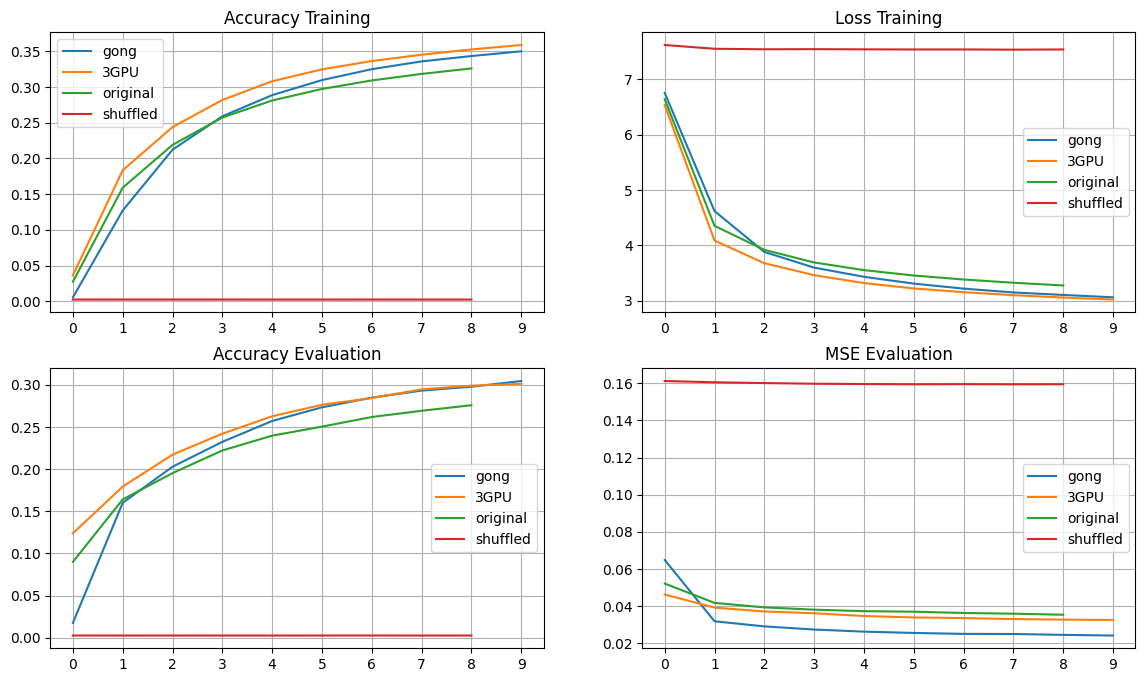

In [13]:
# plot all the stats
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(acc_tr_gong[:10], label='gong')
axs[0, 0].plot(acc_tr_3GPU[:10], label='3GPU')
axs[0, 0].plot(acc_tr_original, label='original')
axs[0, 0].plot(acc_tr_shuffled, label='shuffled')
axs[0, 0].set_title('Accuracy Training')
axs[0, 0].set_xticks(np.arange(0, 10, 1))
axs[0, 0].legend()
axs[0, 0].grid()


axs[0, 1].plot(loss_tr_gong[:10], label='gong')
axs[0, 1].plot(loss_tr_3GPU[:10], label='3GPU')
axs[0, 1].plot(loss1_tr_original+10*loss2_tr_original, label='original')
axs[0, 1].plot(loss1_tr_shuffled+10*loss2_tr_shuffled, label='shuffled')
axs[0, 1].set_title('Loss Training')
axs[0, 1].set_xticks(np.arange(0, 10, 1))
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(acc_ev_gong[:10], label='gong')
axs[1, 0].plot(acc_ev_3GPU[:10], label='3GPU')
axs[1, 0].plot(acc_ev_original, label='original')
axs[1, 0].plot(acc_ev_shuffled, label='shuffled')
axs[1, 0].set_title('Accuracy Evaluation')
axs[1, 0].set_xticks(np.arange(0, 10, 1))
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(mse_ev_gong[:10], label='gong')
axs[1, 1].plot(mse_ev_3GPU[:10], label='3GPU')
axs[1, 1].plot(loss2_ev_original, label='original')
axs[1, 1].plot(loss2_ev_shuffled, label='shuffled')
axs[1, 1].set_title('MSE Evaluation')
axs[1, 1].set_xticks(np.arange(0, 10, 1))
axs[1, 1].legend()
axs[1, 1].grid()

plt.show()

## testing the dataloader

In [14]:
# Navigate up one level to the 'pretraining' directory, where 'dataloader.py' is located
sys.path.append(os.path.abspath('../'))

import dataloader

In [15]:
train_loader = torch.utils.data.DataLoader(
    dataloader.AudioDataset(
        dataset_json_file='/home/bosfab01/SpeakerVerificationBA/data/audioset2M_librispeech960.json',
        audio_conf={
            'num_mel_bins': 128,
            'target_length': 998,
            'freqm': 0,
            'timem': 0,
            'mixup': 0,
            'dataset': 'asli',
            'mean': -3.6925695,
            'std': 4.020388,
            'noise': False,
            'mode': 'train',
            'shuffle_frames': False
        },
        label_csv='/home/bosfab01/SpeakerVerificationBA/data/label_information.csv'
    ),
    batch_size=24,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    drop_last=True
)

---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process asli
use dataset mean -3.693 and std 4.020 to normalize the input.
number of classes is 1


### get one batch of data from the dataloader and display the images

In [16]:
# Create an iterator from the DataLoader
data_iterator = iter(train_loader)

# Fetch the first batch
audio_input, labels = next(data_iterator)

# Print out the details to see what the batch contains
print("Audio input shape:", audio_input.shape)
print("Labels shape:", labels.shape)

Audio input shape: torch.Size([24, 998, 128])
Labels shape: torch.Size([24, 1])


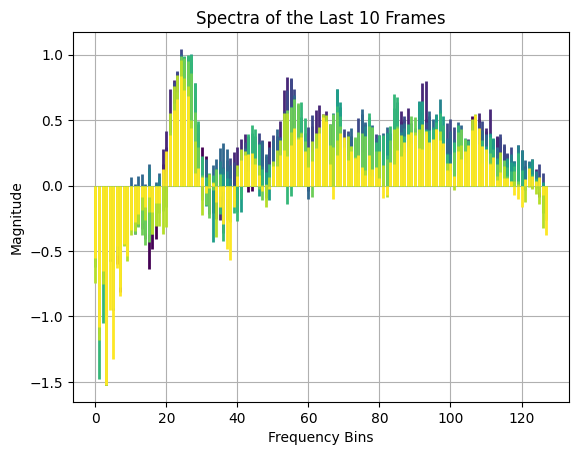

tensor([-0.5499, -1.0772, -0.6490, -1.5235, -0.9525, -1.3229, -0.6265, -0.8462,
        -0.4470, -0.5346, -0.3392, -0.2793, -0.2188, -0.0874, -0.1639, -0.0854,
        -0.2009, -0.1331, -0.1322,  0.1307,  0.2631,  0.3890,  0.5801,  0.6631,
         0.8383,  0.7318,  0.6816,  0.4415,  0.1000,  0.1323,  0.0654, -0.0590,
        -0.0209,  0.0173, -0.1284, -0.1667, -0.2954, -0.4830, -0.5678, -0.1646,
         0.0731,  0.1990,  0.2323,  0.2454,  0.2511,  0.1659,  0.0846, -0.0391,
         0.0018, -0.0250,  0.1477,  0.1493,  0.2316,  0.2746,  0.2253,  0.3113,
         0.4387,  0.3556,  0.3722,  0.2626,  0.1430,  0.1912,  0.2909,  0.4052,
         0.5206,  0.4964,  0.1663, -0.1015,  0.2368,  0.4009,  0.3716,  0.1986,
         0.2609,  0.2141,  0.2310,  0.1415,  0.0797,  0.2321,  0.1241,  0.1414,
         0.0564, -0.0965, -0.0735,  0.1812,  0.1648,  0.2728,  0.2270,  0.3312,
         0.3975,  0.4115,  0.3847,  0.2862,  0.2808,  0.4156,  0.3325,  0.3584,
         0.4353,  0.3465,  0.3235,  0.12

In [17]:
# print the last 10 spectra of the first sample in the batch
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # Generate 10 colors from the 'viridis' colormap

for i in range(10, 0, -1):
    markerline, stemlines, baseline = plt.stem(audio_input[0, -i, :], linefmt='-', basefmt=" ")
    plt.setp(stemlines, 'linewidth', 2, 'color', colors[10-i])  # Set the color and line width
    plt.setp(markerline, 'marker', '')  # No marker at the end

#plt.legend([f'Spectrum {-i}' for i in range(10, 0, -1)])
plt.xlabel('Frequency Bins')
plt.ylabel('Magnitude')
plt.title('Spectra of the Last 10 Frames')
plt.grid(True)
plt.show()

# Print the last spectrum of the first sample
print(audio_input[0, -1, :])

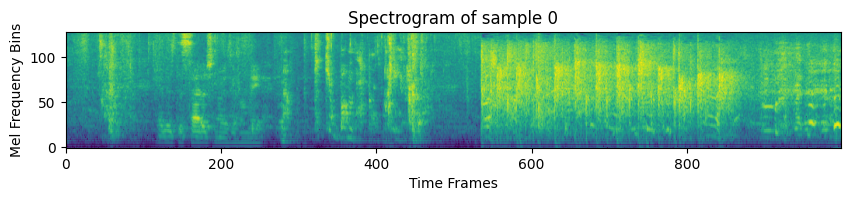

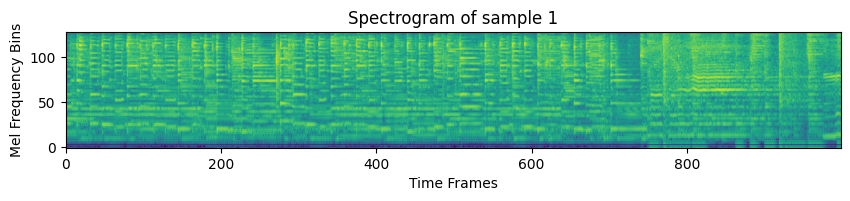

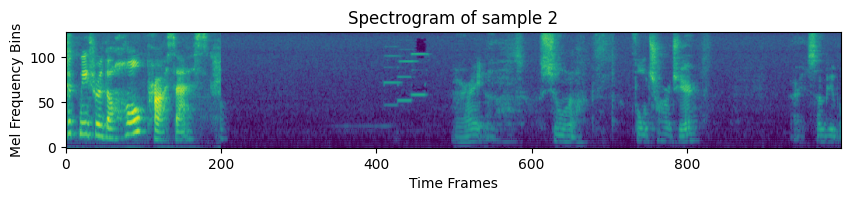

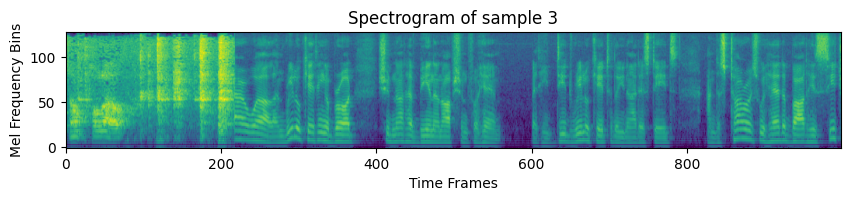

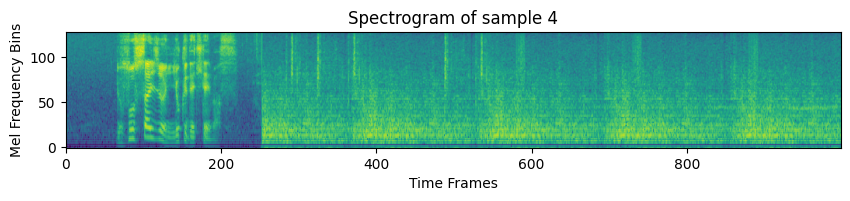

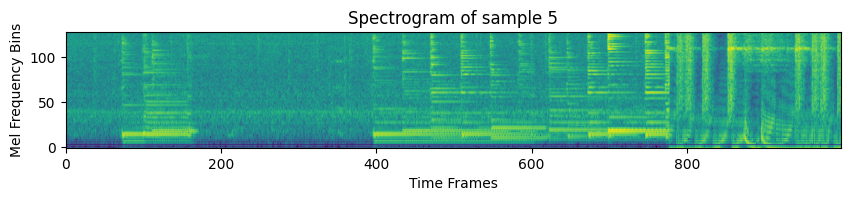

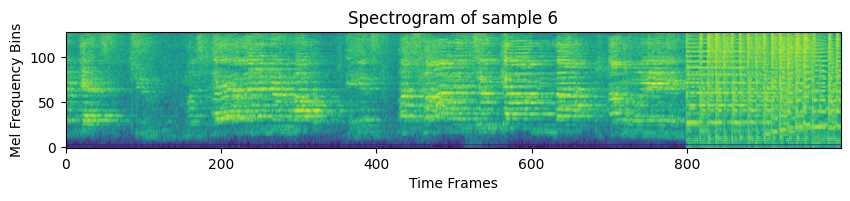

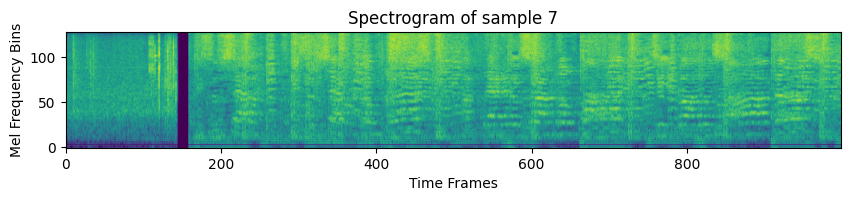

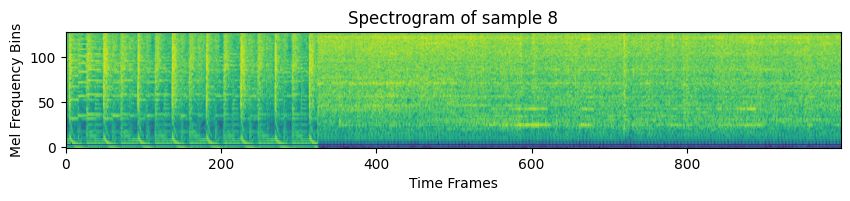

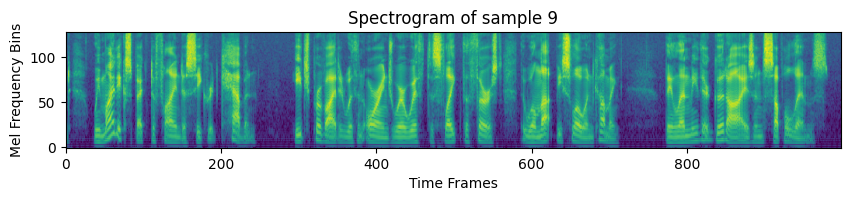

In [18]:
# Adjusted function to plot a spectrogram with the correct orientation
def plot_spectrogram(spectrogram, ax, title="Spectrogram"):
    # Transpose the spectrogram to align the axes correctly
    ax.imshow(spectrogram.T.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(title)
    ax.set_xlim(0, spectrogram.shape[0])
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')

for i in range(10):
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plot_spectrogram(audio_input[i, :, :], ax, title=f'Spectrogram of sample {i}')
    plt.show()

## visualize audio signal and spectrogram

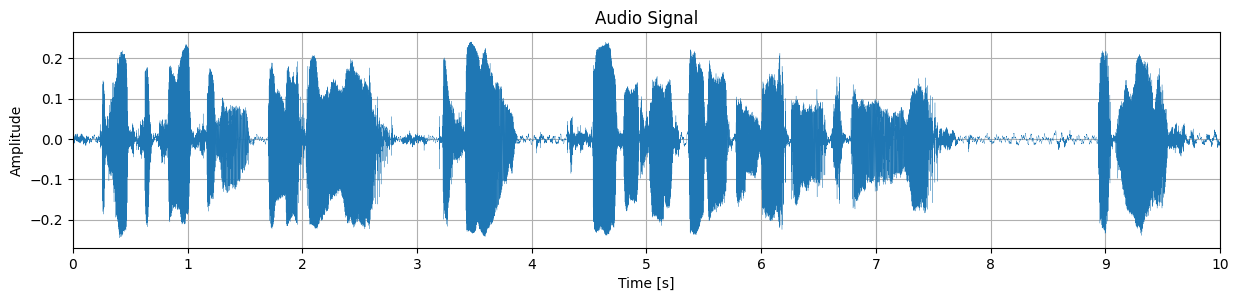

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000


In [19]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch

# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Plot the audio signal
plt.figure(figsize=(14.8, 2.8))
plt.plot(time, audio_signal, linewidth=0.2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])
plt.title('Audio Signal')
plt.grid(True)
plt.show()

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)

torch.Size([160000])
torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])


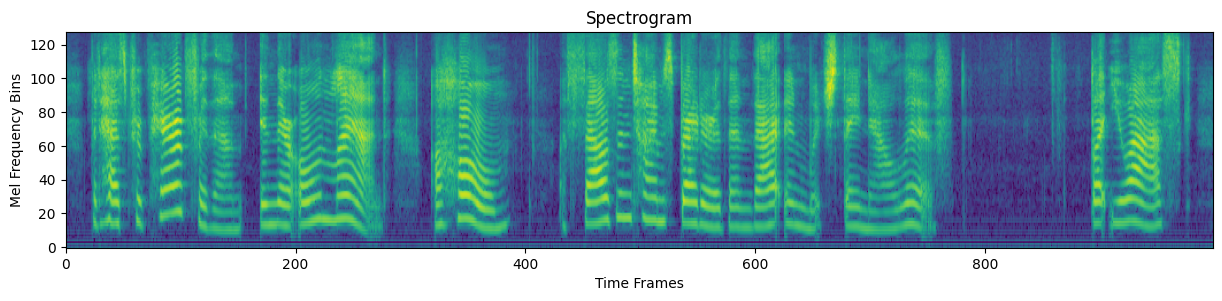

In [20]:
# test the function torchaudio.compliance.kaldi.fbank for the first audio signal

# Assuming `audio_signal` is a NumPy array and `sample_rate` is defined
# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print(audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0) # Add batch and channel dimensions
print(audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")

# plot the fbank features
fig, ax = plt.subplots(figsize=(14.8, 2.8))
plot_spectrogram(fbank_features, ax)


### plot both the audio signal and its spectrogram below it

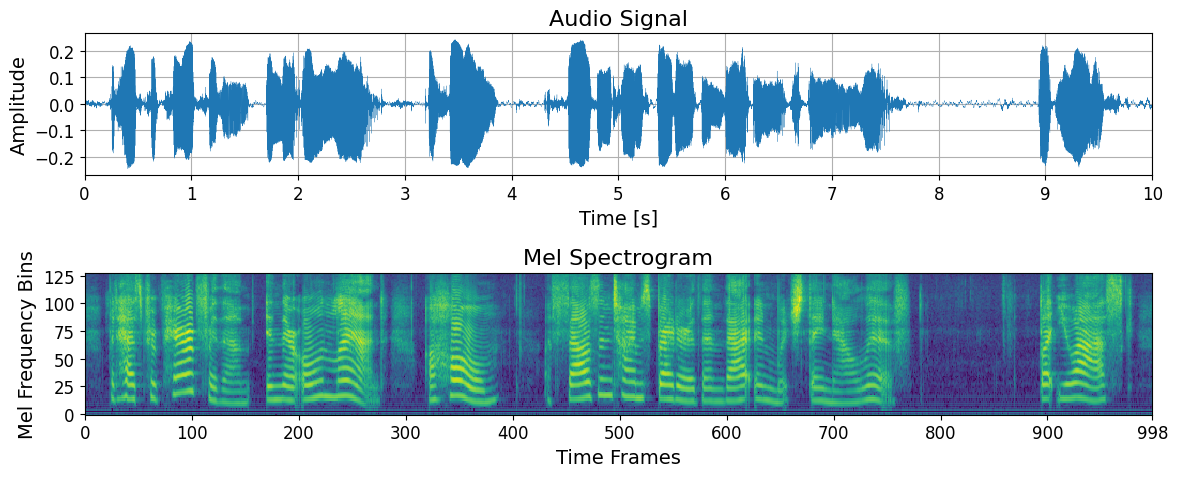

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Setting global parameters for all text
plt.rcParams.update({
    'font.size': 14,        # Sets the base default size of fonts
    'axes.titlesize': 16,   # Specifically the title size
    'axes.labelsize': 14,   # Size of axis labels
    'xtick.labelsize': 12,  # Size of the tick labels
    'ytick.labelsize': 12   # Size of the tick labels
})


# Function to plot spectrogram
def plot_spectrogram(spectrogram, ax, title="Mel Spectrogram"):
    # Assuming spectrogram data is on a tensor and needs to be moved to CPU and converted to numpy array
    ax.imshow(spectrogram.T.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis', interpolation='none')
    ax.set_title(title)
    ax.set_xticks(np.concatenate((np.arange(0, 1000, 100), [spectrogram.shape[0]])))
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')

def plot_spectrogram_mesh(spectrogram, ax, title="Spectrogram"):
    # Convert tensor to numpy if necessary
    data = spectrogram.T.cpu().numpy()
    # Create a meshgrid for the x and y dimensions
    x = np.linspace(0, data.shape[1], data.shape[1])
    y = np.linspace(0, data.shape[0], data.shape[0])
    X, Y = np.meshgrid(x, y)
    # Use pcolormesh to plot data
    pcm = ax.pcolormesh(X, Y, data, shading='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')
    # Optionally add a colorbar
    #plt.colorbar(pcm, ax=ax)

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))  # Adjust total figure size as needed

# Plot the audio signal
ax1.plot(time, audio_signal, linewidth=0.2)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_yticks(np.arange(-0.2, 0.3, 0.1))
ax1.set_xlim([0, 10])
ax1.set_title('Audio Signal')
ax1.grid(True)

# Plot the fbank features using the defined function
plot_spectrogram(fbank_features, ax2)

# Adjust layout so plots do not overlap
plt.tight_layout()

# Save the figure as a PDF file
plt.savefig('waveform_spectrogram.pdf', dpi=10000)

# Show the figure
plt.show()